In [ ]:
import sys
!{sys.executable} -m pip install yfinance statsmodels

In [2]:
import pandas as pd
import numpy as np
import yfinance
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
# Get SPY data, an ETF that tracks S&P 500
# Print out available data

stock_ticker = 'SPY'

stock_info = yfinance.Ticker(stock_ticker)
for key,value in stock_info.info.items():
    print(key, ":", value)

longBusinessSummary : The Trust seeks to achieve its investment objective by holding a portfolio of the common stocks that are included in the index (the “Portfolio”), with the weight of each stock in the Portfolio substantially corresponding to the weight of such stock in the index.
maxAge : 86400
priceHint : 2
previousClose : 522.2
open : 522.11
dayLow : 520.97
dayHigh : 522.6001
regularMarketPreviousClose : 522.2
regularMarketOpen : 522.11
regularMarketDayLow : 520.97
regularMarketDayHigh : 522.6001
trailingPE : 26.255684
volume : 65751503
regularMarketVolume : 65751503
averageVolume : 75358231
averageVolume10days : 76705560
averageDailyVolume10Day : 76705560
bid : 520.7
ask : 520.9
bidSize : 3000
askSize : 800
yield : 0.012999999
totalAssets : 503321591808
fiftyTwoWeekLow : 393.69
fiftyTwoWeekHigh : 524.11
fiftyDayAverage : 499.6532
twoHundredDayAverage : 458.8577
trailingAnnualDividendRate : 5.662
trailingAnnualDividendYield : 0.010842589
navPrice : 521.41223
currency : USD
catego

In [4]:
# Get 10 years of historic weekly price data

start_date = '2014-03-10'
end_date = '2024-03-10'

stock_info_price = stock_info.history(start=start_date, end=end_date, interval='1wk')
stock_info_price.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2014-03-10 00:00:00-04:00,156.398038,157.013750,153.460948,153.643997,587706600,0.000,0.0,0.0
2014-03-17 00:00:00-04:00,154.417811,157.271705,154.317970,154.925354,656800400,0.825,0.0,0.0
2014-03-24 00:00:00-04:00,156.143916,156.561771,153.686929,155.015717,589131000,0.000,0.0,0.0
2014-03-31 00:00:00-04:00,156.001921,158.534120,155.040860,155.776276,514528000,0.000,0.0,0.0
2014-04-07 00:00:00-04:00,155.400189,156.419755,151.522497,151.689636,693927000,0.000,0.0,0.0


[Text(0.5, 1.0, 'Daily Close Values over Time')]

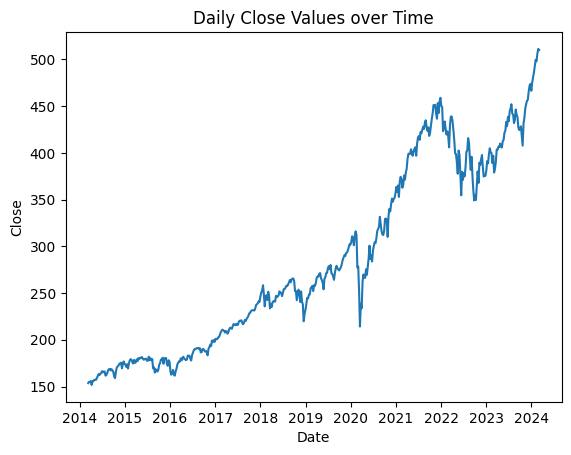

In [5]:
# Plot price change over time

sns.lineplot(stock_info_price, x='Date', y='Close').set(title='Daily Close Values over Time')

In [6]:
# We'll model on the log of daily changes to minimize some variation

stock_info_price['weekly_return'] = stock_info_price['Close'].diff()
stock_info_price.dropna(inplace=True)
stock_info_price.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,weekly_return
Date,,,,,,,,,
2014-03-17 00:00:00-04:00,154.417811,157.271705,154.317970,154.925354,656800400,0.825,0.0,0.0,1.281357
2014-03-24 00:00:00-04:00,156.143916,156.561771,153.686929,155.015717,589131000,0.000,0.0,0.0,0.090363
2014-03-31 00:00:00-04:00,156.001921,158.534120,155.040860,155.776276,514528000,0.000,0.0,0.0,0.760559
2014-04-07 00:00:00-04:00,155.400189,156.419755,151.522497,151.689636,693927000,0.000,0.0,0.0,-4.086639
2014-04-14 00:00:00-04:00,152.876308,156.202440,151.631109,155.767868,499927000,0.000,0.0,0.0,4.078232


[Text(0.5, 1.0, 'Daily Return Values over Time')]

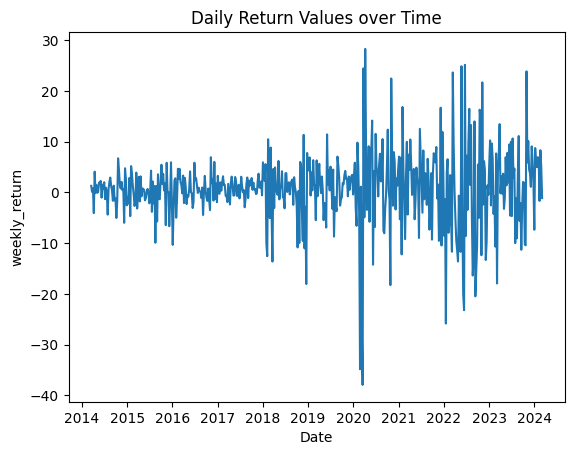

In [7]:
sns.lineplot(stock_info_price, x='Date', y='weekly_return').set(title='Daily Return Values over Time')

In [8]:
# Apply Dickey Fuller test
# Look at raw vs. daily return

# Raw

ad_fuller = adfuller(stock_info_price['Close'])
print('Augmented Dickey Fuller test on raw close data')
print(ad_fuller)
ad_fuller_daily = adfuller(stock_info_price['weekly_return'])
print('Augmented Dickey Fuller test on daily return')
print(ad_fuller_daily)

Augmented Dickey Fuller test on raw close data
(0.23032627733967034, 0.9739121206334777, 0, 520, {'1%': -3.4429882202506255, '5%': -2.8671142122781066, '10%': -2.569738849852071}, 3402.032161408882)
Augmented Dickey Fuller test on daily return
(-24.213786560230687, 0.0, 0, 520, {'1%': -3.4429882202506255, '5%': -2.8671142122781066, '10%': -2.569738849852071}, 3400.1845039458017)


Note that for the SPY ticker at least, on the raw close data the ADF statistic is not more negative than the critical values, and the p value is high, indicating the data is not stationary

For the daily return data, the ADF statistic is less than the critical values and the p value is very low, indicating the data is stationary. We will use the daily return data for this exercise

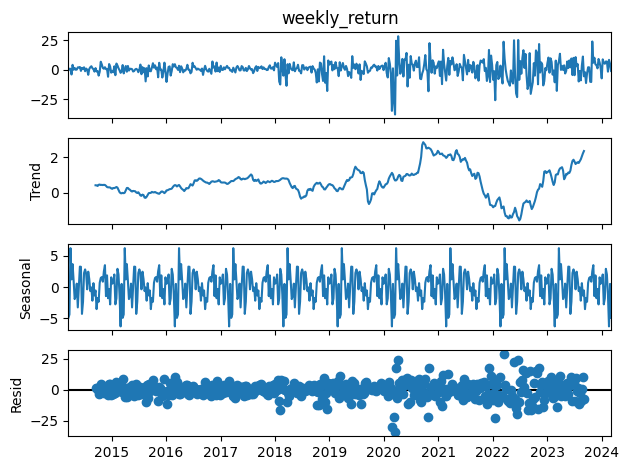

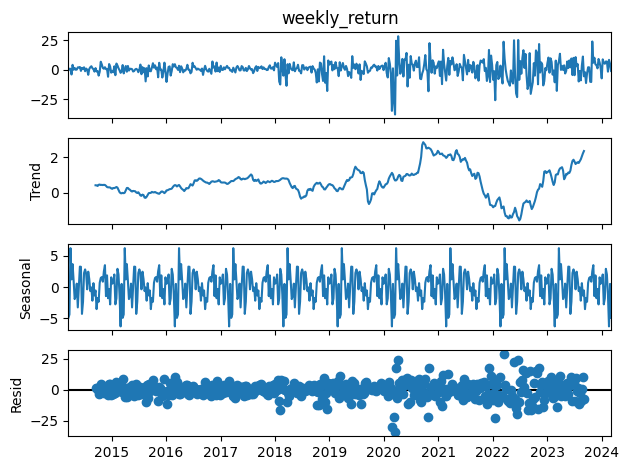

In [9]:
# Decompose seasonality and trend

decompose_dataset = pd.DataFrame({'weekly_return': stock_info_price['weekly_return'], 'date': pd.to_datetime(stock_info_price.index)})
decompose_dataset = decompose_dataset.set_index('date')
decompose_dataset.index.freq = 'W-MON' # Necessary to get seasonal_decompose to execute

decomposition = seasonal_decompose(decompose_dataset['weekly_return'], model='additive')
trend = pd.DataFrame(decomposition.trend)
seasonal = pd.DataFrame(decomposition.seasonal)
residual = pd.DataFrame(decomposition.resid)
decomposition.plot()

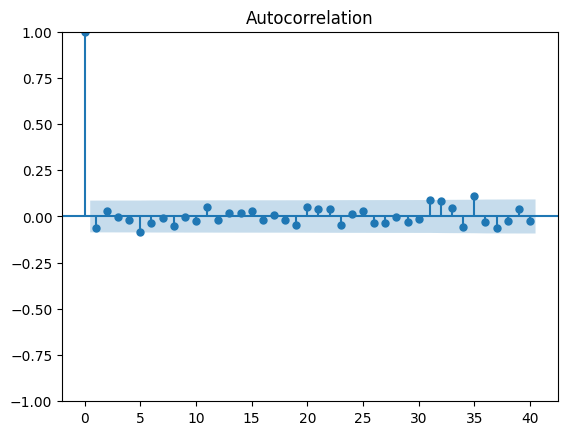

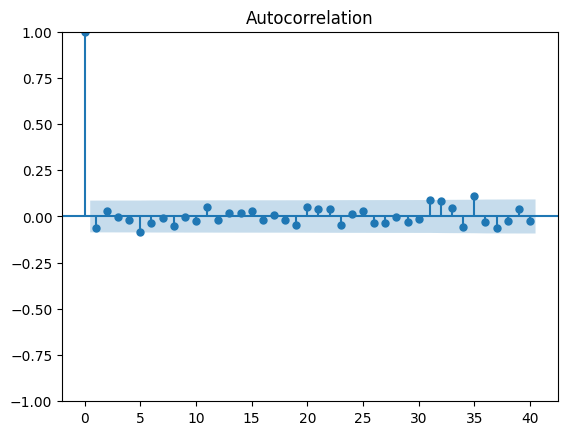

In [10]:
plot_acf(stock_info_price['weekly_return'], lags = 40)

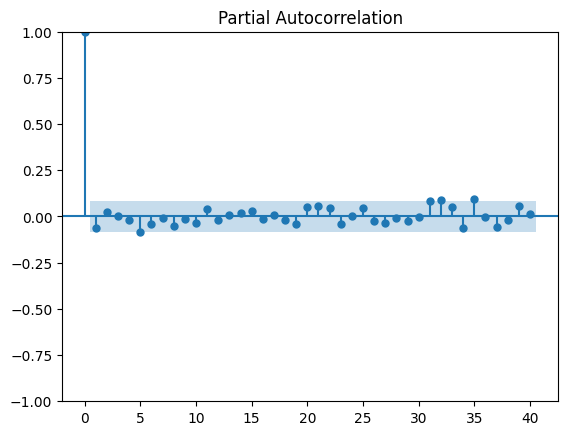

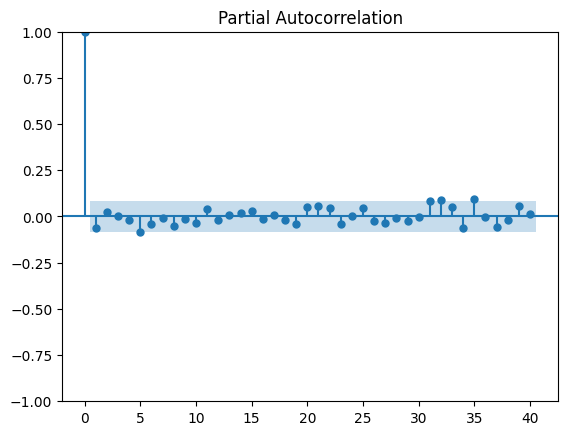

In [11]:
plot_pacf(stock_info_price['weekly_return'], lags = 40)

In [12]:
# Let's use all data until 2024 to train the model, then predict 2024 data from there

stock_info_train = stock_info_price[stock_info_price.index < '2024-01-01']
stock_info_test = stock_info_price[stock_info_price.index >= '2024-01-01']
arima = ARIMA(stock_info_train['Close'], order=(20,1,13))

/Users/Wesley/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/Wesley/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/Wesley/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [13]:
model_fit = arima.fit()
train_preds = model_fit.predict()

/Users/Wesley/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Wesley/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Wesley/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
test_preds = model_fit.forecast(steps=13, alpha=0.05)

/Users/Wesley/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


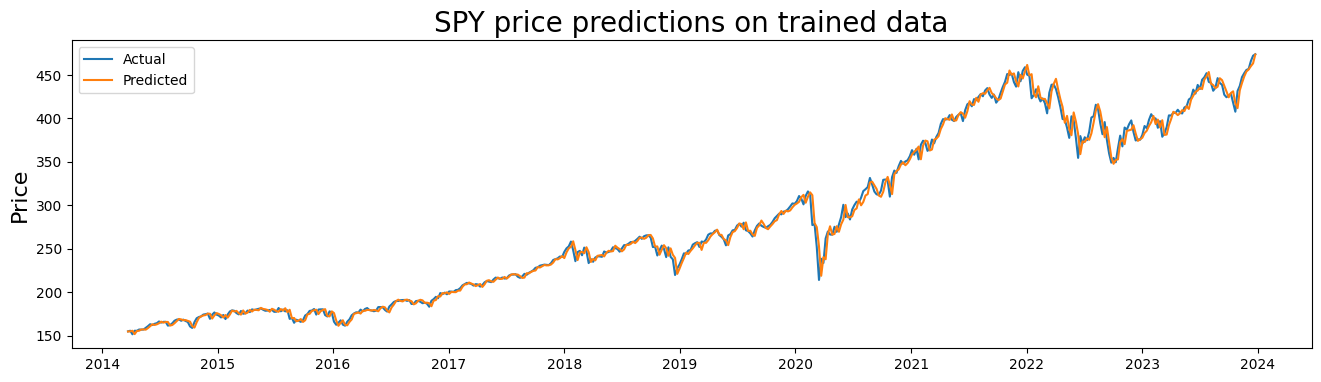

In [15]:
# Lines up really close with historic data
# But a closer inspection shows it's a day or so behind, but catches up quickly

plt.figure(figsize=(16,4))
plt.plot(stock_info_train['Close'][1:], label="Actual")
plt.plot(train_preds[1:], label="Predicted")
plt.title(f'{stock_ticker} price predictions on trained data', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.legend()

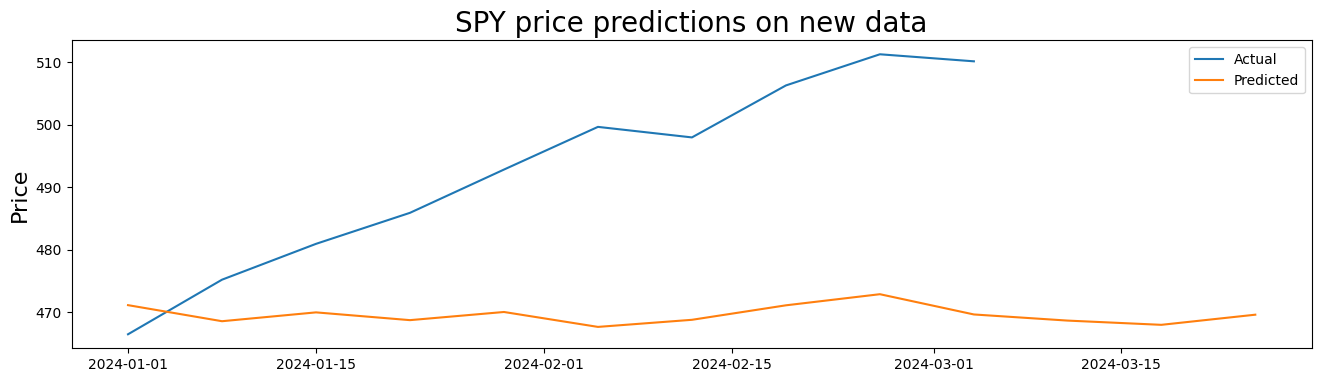

In [16]:
# Clearly extremely overfit!
# Predicting the stock market is hard (impossible)!
# You can see this model does not hold up when it doesn't have the benefit of very recent data

plt.figure(figsize=(16,4))
plt.plot(stock_info_test['Close'], label="Actual")
plt.plot(test_preds, label="Predicted")
plt.title(f'{stock_ticker} price predictions on new data', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.legend()